In [3]:
from umap import UMAP
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from cuml.cluster import KMeans

data_dir = "/home/sdl/SDL-LNP/model/evaluation/notebooks/"

pred_res_path = data_dir + "test_result.csv"
embeddings_path = data_dir + "test_result_representation.npz"

pred_res = pd.read_csv(pred_res_path)
with np.load(embeddings_path) as data:
    embeddings = data["arr_0"]
    
mean_pred_res = pred_res.groupby("smi_name").mean()
# get mean embedding with same smi_name
smi_names = pred_res["smi_name"].unique()
embeddings_df = pd.DataFrame(embeddings, index=pred_res["smi_name"])
# mean_embeddings = embeddings_df.groupby("smi_name").mean()

# get first embedding with same smi_name
mean_embeddings = embeddings_df.groupby("smi_name").first()

MAPPING_PATH = "/home/sdl/SDL-LNP/model/data_process/220k_library.csv"
mapping_df = pd.read_csv(MAPPING_PATH)
NAME_SMI_PATH = "/home/sdl/SDL-LNP/mapping_table/General_mapping_sampler.csv"
name_smi_df = pd.read_csv(NAME_SMI_PATH)

mean_pred_res = pred_res.groupby("smi_name").mean()
# get mean embedding with same smi_name
smi_names = pred_res["smi_name"].unique()
embeddings_df = pd.DataFrame(embeddings, index=pred_res["smi_name"])
# mean_embeddings = embeddings_df.groupby("smi_name").mean()

# get first embedding with same smi_name
mean_embeddings = embeddings_df.groupby("smi_name").first()


In [4]:
df = mean_embeddings
# to float32
df = df.astype(np.float32)


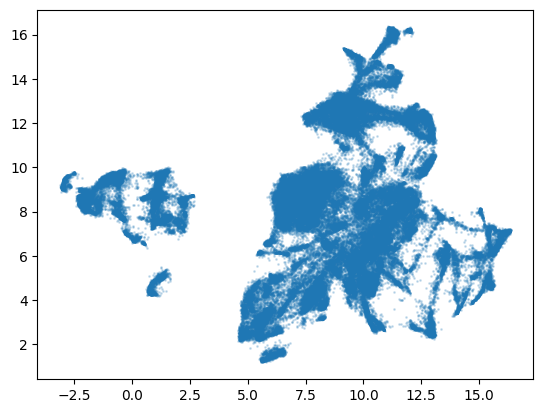

In [5]:
# plot umap
umap = UMAP()
umap_embedding = umap.fit_transform(df)
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], alpha=0.2, s=1)


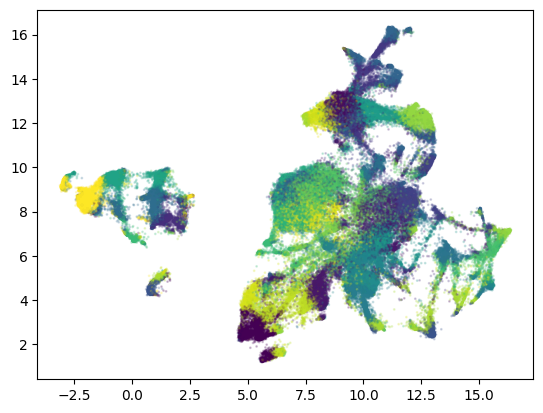

In [6]:
# kmeans clustering with cuml
kmeans = KMeans(n_clusters=32)
kmeans.fit(df)

# plot kmeans
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=kmeans.labels_, alpha=0.2, s=1)

In [7]:
# get cluster size
cluster_size = np.bincount(kmeans.labels_)
cluster_size

array([4240, 3285, 4398, 4189, 2742, 3028, 5401, 2966, 2067, 2532, 4788,
       3851, 3166, 3068, 3850, 3771, 2877, 2997, 3531, 2765, 3368, 2811,
       2024, 3588, 3805, 3290, 4722, 2944, 4276, 3036, 3169, 4047])

In [21]:
def sampling(n_query, clusters, query_idx):
    sample_res = []
    idx2cluster_mapping = {idx: clusters[idx] for idx in query_idx}
    cluster2size_mapping = {i: np.sum(clusters == i) for i in np.unique(clusters)}
    cluster2idx_mapping = {i: [] for i in np.unique(clusters)}
    for idx, cluster in idx2cluster_mapping.items():
        cluster2idx_mapping[cluster].append(idx)
    sorted_clusters = sorted(cluster2size_mapping.keys(), 
                             key=lambda x: cluster2size_mapping[x])
    # round robin sampling
    j = 0
    while len(sample_res) < n_query:
        cluster = sorted_clusters[j % len(sorted_clusters)]
        cluster_indices = cluster2idx_mapping[cluster]
        if len(cluster_indices) == 0:
            j += 1
            continue
        selected_idx = np.random.choice(cluster_indices, 1)[0]
        # remove selected index from cluster2idx_mapping
        cluster2idx_mapping[cluster].remove(selected_idx)
        cluster2size_mapping[cluster] -= 1
        sample_res.append(selected_idx)
        print(f"selected_idx: {selected_idx} from cluster {cluster}; cluster size: {cluster2size_mapping[cluster]}")
        j += 1
    

    return sample_res

In [22]:
query_idx = np.argsort(np.random.rand(df.shape[0]))[:1000]

sample_res = sampling(40, kmeans.labels_[query_idx], query_idx)

print(sample_res)


selected_idx: 61810 from cluster 17; cluster size: 16
selected_idx: 74269 from cluster 8; cluster size: 17
selected_idx: 27666 from cluster 22; cluster size: 17
selected_idx: 48468 from cluster 5; cluster size: 19
selected_idx: 18939 from cluster 27; cluster size: 19
selected_idx: 88968 from cluster 21; cluster size: 20
selected_idx: 68244 from cluster 14; cluster size: 21
selected_idx: 47942 from cluster 7; cluster size: 22
selected_idx: 73235 from cluster 29; cluster size: 22
selected_idx: 75883 from cluster 4; cluster size: 26
selected_idx: 29662 from cluster 13; cluster size: 27
selected_idx: 11235 from cluster 9; cluster size: 28
selected_idx: 23333 from cluster 25; cluster size: 29
selected_idx: 26969 from cluster 1; cluster size: 30
selected_idx: 1794 from cluster 30; cluster size: 30
selected_idx: 9371 from cluster 3; cluster size: 32
selected_idx: 99793 from cluster 11; cluster size: 33
selected_idx: 34843 from cluster 18; cluster size: 33
selected_idx: 16513 from cluster 12; 